# Imports

In [90]:
from abc import ABC, abstractmethod
import operator
from typing import Optional, Tuple, TypeVar
import warnings

import numpy as np
import pandas as pd
import pmdarima as pm
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import quantstats
from scipy import signal
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm


pyo.init_notebook_mode()
warnings.simplefilter('ignore', ConvergenceWarning)
%matplotlib widget


# Utility functions

## Loading data

In [37]:
def read_sheet(sheet_name):
    df = (
        pd.read_excel(xlsx, sheet_name)
        .iloc[:-1]
        .astype({"Price": float, "Open": float, "High": float, "Low": float})
        .set_index("Date")
        .sort_index(ascending=True)
    )
    df.index = df.index.to_period('D')
    return df

## Plotting

In [38]:
def plot_candlesticks(ohlcv: pd.DataFrame):
    fig = go.Figure(data=[go.Candlestick(
        x=ohlcv.index.to_timestamp(),
        open=ohlcv['Open'],
        high=ohlcv['High'],
        low=ohlcv['Low'],
        close=ohlcv["Price"]
    )])

    fig.update_layout(height=500, xaxis_rangeslider_visible=False)
    return fig


def plot_forecast(signal_train, signal_test, forecast):
    return go.Figure(
        data=[
            go.Scatter(x=signal_train.index.to_timestamp(), y=signal_train, name="Train data", line_color="green"),
            go.Scatter(x=signal_test.index.to_timestamp(), y=signal_test, name="Test data", line_color="red"),
            go.Scatter(x=signal_test.index.to_timestamp(), y=forecast, name="Forecast", line_color="blue"),
        ],
        layout=dict(height=500)
    )

## Modeling

In [39]:
T = TypeVar('T', bound='TimeSeriesModel')


class TimeSeriesModel(ABC):
    def __init__(self):
        self.history = None
        
    @abstractmethod
    def fit(self: T, history: pd.Series, exog: Optional[pd.Series] = None) -> T:
        """
        Fits the model onto the history time series as training data.
        :return: the same TimeSeriesModel instance
        :rtype: :class:`TimeSeriesModel`
        """
        self.history = history
        return self

    @abstractmethod
    def update(self: T, value) -> T:
        """
        Fits the model adding the new value to the history
        :return: the same TimeSeriesModel instance
        :rtype: :class:`TimeSeriesModel`
        """

    @abstractmethod
    def forecast(self, exog=None) -> float:
        """
        Forecast next value in time series
        """


class StatsmodelsTimeSeriesModelWrapper(TimeSeriesModel):
    def __init__(self, model_class, use_exogenous=True, **hyperparameters):
        self.model_class = model_class
        self.hyperparameters = hyperparameters
        self.use_exogenous = use_exogenous
        self.model = None
        self.history = None
        self.exogenous = None

    def __getattr__(self, attr):
        if self.model is not None:
            return getattr(self.model, attr)
    
    def fit(self, history, exog=None):
        if exog is not None and self.use_exogenous:
            self.model = self.model_class(history, exog=exog, **self.hyperparameters).fit()
        else:
            self.model = self.model_class(history, **self.hyperparameters).fit()
        self.history = history
        self.exogenous = exog
        return self

    def update(self, value, exog=None):
        new_history = np.concatenate((self.history, np.array([value])))
        if exog is not None and self.use_exogenous:
            new_exogenous = np.concatenate((self.exogenous, np.array([exog])))
        else:
            new_exogenous = None
        self.fit(new_history, new_exogenous)

    def forecast(self, exog=None):
        if exog is not None and self.use_exogenous:
            return self.model.forecast(exog=np.array(exog).reshape((-1, 1)))
        else:
            return self.model.forecast()


class AutoArimaWrapper(TimeSeriesModel):
    def __init__(self, use_exogenous=True, **hyperparameters):
        self.hyperparameters = hyperparameters
        self.use_exogenous = use_exogenous
        self.model = None

    def __getattr__(self, attr):
        if self.model is not None:
            return getattr(self.model, attr)
    
    def fit(self, history, exog=None):
        if exog is not None and self.use_exogenous:
            self.model = pm.auto_arima(
                history,
                exog.values.reshape((-1, 1)),
                **self.hyperparameters
            )
        else:
            self.model = pm.auto_arima(
                history,
                **self.hyperparameters
            )
        return self

    def update(self, value, exog=None):
        if exog is not None and self.use_exogenous:
            return self.model.update(value, X=np.array(exog).reshape(1, -1))

    def forecast(self, exog=None):
        if exog is not None and self.use_exogenous:
            return self.model.predict(n_periods=1, X=np.array(exog).reshape((-1, 1)))
        else:
            return self.model.predict(n_periods=1)

        
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    print(f"pvalue: {pvalue}")
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

## Forecasting

In [40]:
def time_series_rolling_forecast(model: TimeSeriesModel, train, test, exog_train=None, exog_test=None):    
    predictions = []

    exog_test_iterable = exog_test if exog_test is not None else [None] * len(test)

    if exog_train is not None:
        model.fit(train, exog=exog_train)
    else:
        model.fit(train)
    
    for value, exog in tqdm(zip(test, exog_test_iterable), total=len(test), desc="Rolling forecast", leave=False):
        forecast = model.forecast(exog=exog)
        model.update(value, exog=exog)
        predictions.append(forecast[0])
            
    return pd.Series(predictions)


## Evaluation

In [41]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return ((y_pred - y_true).abs().sum() / y_true.sum()) * 100


def get_sign_accuracy(y_true, y_pred):
    true_sign = pd.Series(y_true).diff().iloc[1:] > 0
    pred_sign = pd.Series(y_pred).diff().iloc[1:] > 0

    return (true_sign == pred_sign).mean()


def show_results(train_series, test_series, forecasted_series):
    mape = mean_absolute_percentage_error(test_series.values, forecasted_series)
    fig = plot_forecast(train_series, test_series, forecasted_series)
    fig.update_layout(title=f"MAPE: {mape:.2f}")
    return fig


import quantstats


def get_strategy_returns(strategy):
    pyfolio_analysis = strategy.analyzers.getbyname("PyFolio")
    returns, positions, transactions, gross_lev = pyfolio_analysis.get_pf_items()
    returns.index = returns.index.tz_convert(None)
    return returns
    

def get_strategy_stats(strategy):
    returns = get_strategy_returns(strategy)
    return {
        'Sharpe Ratio': quantstats.stats.sharpe(returns),
        "Profit": quantstats.stats.comp(returns),
    }


def plot_strategy_result(strategy):
    returns = get_strategy_returns(strategy)
    return quantstats.plots.snapshot(returns)


def get_optimum_parameters(cerebro_run):
    optimization_results = [
        dict(
            parameters=vars(strategy.params),
            stats=get_strategy_stats(strategy)
        )
        for iteration in cerebro_run
        for strategy in iteration
    ]
        
    best_result = max(optimization_results, key=lambda results: results["stats"]["Profit"])
    # best_index = optimization_results.index(best_result)

    return best_result["parameters"]

# Load data

In [42]:
data_file = "2020Q1Q2Q3Q4-2021Q1.xlsx"
xlsx = pd.ExcelFile(data_file)
sheet_names = xlsx.sheet_names

dfs = {
    sheet: read_sheet(sheet)
    for sheet in xlsx.sheet_names
}

In [43]:
sheet_names

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

# Stock A

## Exploring

In [15]:
df = dfs[sheet_names[0]]

In [16]:
plot_candlesticks(df)

### Check for stationarity to find the differentiation order

### Find D order

In [17]:
check_stationarity(df.Price)

pvalue: 0.758206636387682
The series is NOT stationary


In [18]:
check_stationarity(df.Price.diff().dropna())

pvalue: 4.6146668027330687e-07
The series is stationary


It seems the order is D=1

In [19]:
price_diff = df.Price.diff().fillna(0)

In [20]:
fig = px.line(price_diff.values)
fig.update_layout(height=500)

### Find AR and MA orders

For the differenced stock price, we can plot the autocorrelation and the partial autocorrelation to find the p (autoregressive) and q (moving average) parameters.

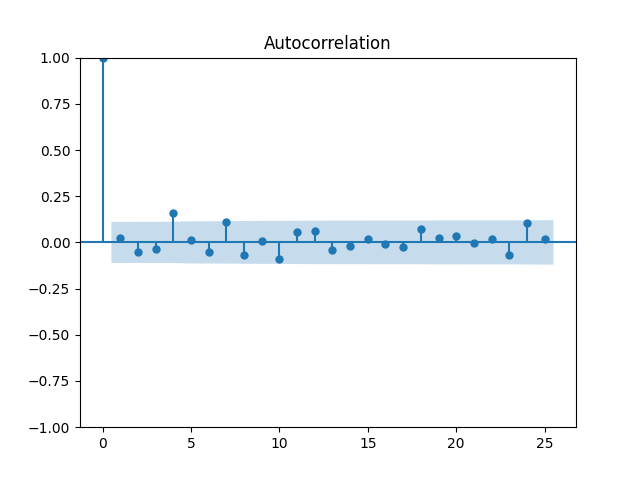

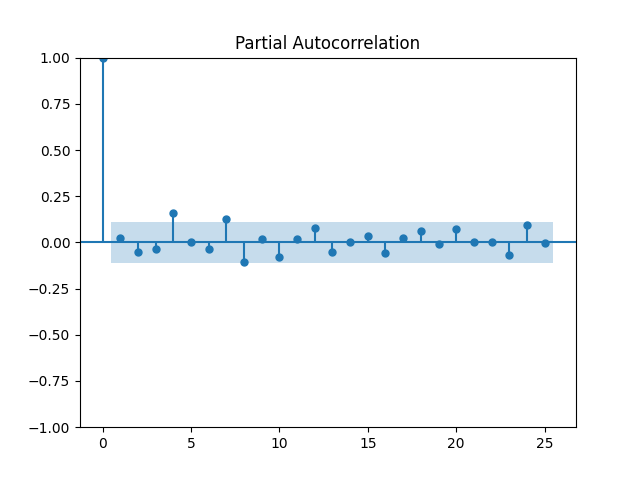

In [21]:
plot_acf(price_diff);
plot_pacf(price_diff);

From a visual inspection, we do not see any significant dependence of the change signal with previous samples.
In any case, we could set P=4 and Q=4 since there seems to be a coefficient in there.

### Check for seasonal component

Let's find first an estimation for the period. The trend is clearly 0, so we can take a look at the spectrum

In [22]:
window = signal.windows.hamming(price_diff.size)
price_diff_windowed = price_diff * window
freq, power_spectral_density = signal.periodogram(price_diff_windowed)
go.Figure(
    go.Scatter(x=freq, y=power_spectral_density),
    layout=dict(height=500)
)

We find two really pronounced peaks at frequencies 0.1 and 0.33, indicating possible periodicities for seasonality of 10 days and 3 days respectively. However there is a lot of noise, so I am not clear that adding this seasonality would be of any help.

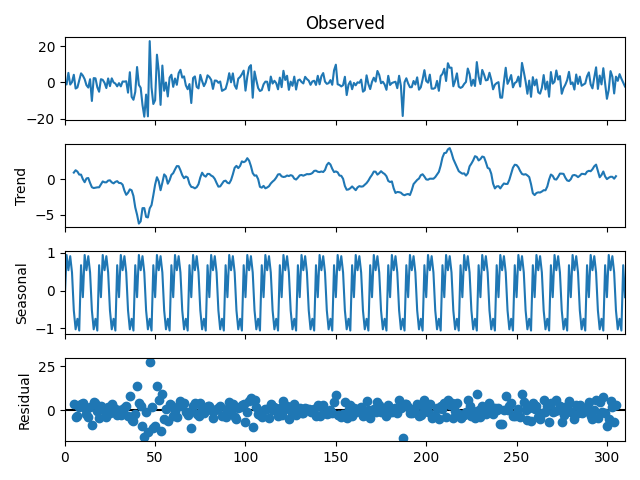

In [23]:
result = seasonal_decompose(price_diff.values, model="additive", period=10)
result.plot();

The seasonal component for a period of 10 samples has an amplitude of 1, which is not too much taking in account that the amplitude of the signal is around 20.
Let's examine its autocorrelation and partial autocorrelation:

pvalue: 0.0
The series is stationary


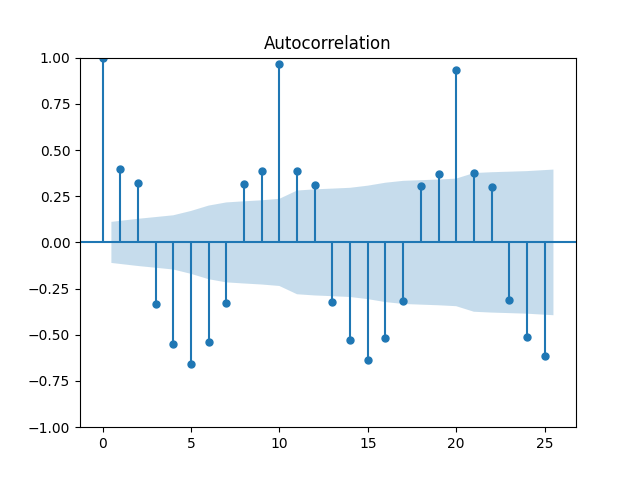

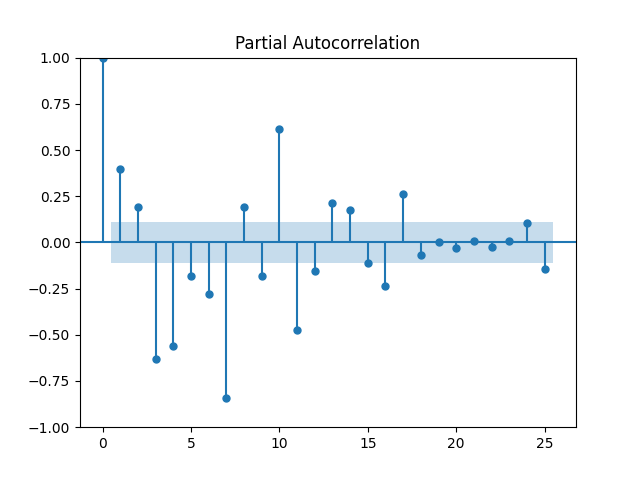

In [24]:
seasonal = result.seasonal
check_stationarity(seasonal)
plot_acf(seasonal);
plot_pacf(seasonal);

## Modeling

In [25]:
is_train = df.index.year < 2021
df_train = df[is_train]
df_test = df[~is_train]

### ARIMA

In [26]:
AR_order = 4
differentiation_order = 1
MA_order = 0

arima_wrapper = StatsmodelsTimeSeriesModelWrapper(ARIMA, order=(AR_order, differentiation_order, MA_order))

forecast_arima = time_series_rolling_forecast(
    arima_wrapper,
    df_train.Price,
    df_test.Price
)

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
show_results(df_train.Price, df_test.Price, forecast_arima)

In [ ]:
AR_order = 4
differentiation_order = 1
MA_order = 4

arima_wrapper = StatsmodelsTimeSeriesModelWrapper(ARIMA, order=(AR_order, differentiation_order, MA_order))

forecast_arima = time_series_rolling_forecast(
    arima_wrapper,
    df_train.Price,
    df_test.Price
)

In [ ]:
show_results(df_train.Price, df_test.Price, forecast_arima)

### SARIMA

In [ ]:
sarimax_wrapper = StatsmodelsTimeSeriesModelWrapper(
    SARIMAX,
    order=(AR_order, differentiation_order, MA_order),
    seasonal_order=(4,0,0,10),
    enforce_stationarity=False
)
        
forecast_sarima = time_series_rolling_forecast(
    sarimax_wrapper,
    df_train.Price,
    df_test.Price
)

In [ ]:
show_results(df_train.Price, df_test.Price, forecast_sarima)

### SARIMAX

In [ ]:
volume = df["Vol."].map(lambda volume: float(volume.rstrip("M")))
volume_previous_day = volume.shift().bfill()
volume_train_previous_day = volume_previous_day[is_train]
volume_test_previous_day = volume_previous_day[~is_train]

In [ ]:
AR_order = 1
differentiation_order = 0
MA_order = 0

sarimax_wrapper = StatsmodelsTimeSeriesModelWrapper(
    SARIMAX,
    order=(AR_order, differentiation_order, MA_order),
    enforce_stationarity=False
)

forecast_sarimax = time_series_rolling_forecast(
    sarimax_wrapper,
    df_train.Price,
    df_test.Price,
    exog_train=volume_train_previous_day,
    exog_test=volume_test_previous_day
)

show_results(df_train.Price, df_test.Price, forecast_sarimax)

### Automatic setting of model parameters (AutoArima)

In [ ]:
model_autoarima = AutoArimaWrapper(
    start_p=1, 
    start_q=1,
    m=10,
    suppress_warnings=False
)

forecast_autoarima = time_series_rolling_forecast(model_autoarima, df_train.Price, df_test.Price, volume_train_previous_day, volume_test_previous_day)

show_results(df_train.Price, df_test.Price, forecast_autoarima)

### Exponential Smoothing

In [ ]:
model_ses = StatsmodelsTimeSeriesModelWrapper(SimpleExpSmoothing)
forecast_ses = time_series_rolling_forecast(model_ses, df_train.Price, df_test.Price)
show_results(df_train.Price, df_test.Price, forecast_ses)

The optimized smoothing parameter value is practically 1, which means the algorithm found all meaningful information for predicting today's price is yesterday's price.

Let's try now with the change in price:

In [ ]:
price_diff = df.Price.diff().fillna(0)
price_diff_train = price_diff[is_train]
price_diff_test = price_diff[~is_train]

In [ ]:
forecast_ses_change = time_series_rolling_forecast(model_ses, price_diff_train, price_diff_test)
show_results(price_diff_train, price_diff_test, forecast_ses_change)

The algorithm can conclude nothing with the difference of price:

In [ ]:
model_ses.params

We can try to add trend prediction to see if it helps

In [ ]:
model_exps = StatsmodelsTimeSeriesModelWrapper(ExponentialSmoothing, trend="add")
forecast_exps = time_series_rolling_forecast(model_exps, df_train.Price, df_test.Price)
show_results(df_train.Price, df_test.Price, forecast_exps)


# All signals

Now we apply the AutoARIMA and SimpleExpSmoothing to all signals and calculate their MAPE:

In [45]:
def process_signal(stock_data: pd.DataFrame, model: TimeSeriesModel):
    def parse_volume(volume_string):
        unit = volume_string[-1]
        try:
            quantity = float(volume_string[:-1])
        except ValueError:
            return 0
            
        if unit == "M":
            return quantity
        elif unit == "K":
            return quantity / 1000
    
    def train_test_split(x):
        is_train = x.index.year < 2021
        return x[is_train], x[~is_train]
    
    price = stock_data["Price"]
    volume = stock_data["Vol."].map(parse_volume)
    volume_previous_day = volume.shift().bfill()
    
    price_train, price_test = train_test_split(price)
    volume_train_previous_day, volume_test_previous_day = train_test_split(volume_previous_day)
    
    forecast = time_series_rolling_forecast(model, price_train, price_test, volume_train_previous_day, volume_test_previous_day)
    mape = mean_absolute_percentage_error(price_test.values, forecast)
    sign_accuracy = get_sign_accuracy(price_test.values, forecast)
    
    fig = show_results(price_train, price_test, forecast);

    return model.summary(), forecast, mape, sign_accuracy, fig

In [46]:
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')


model_autoarima = AutoArimaWrapper(
    start_p=1, 
    start_q=1,
    suppress_warnings=False
)

model_ses = StatsmodelsTimeSeriesModelWrapper(SimpleExpSmoothing, use_exogenous=False)

models = dict(autoarima=model_autoarima, ses=model_ses)

results = defaultdict(dict)
pbar = tqdm(dfs.items())
for sheet, df in pbar:
    pbar.set_description(f"Sheet: {sheet}")
    for name, model in tqdm(models.items(), desc="Models", leave=False):
        results[sheet][name] = process_signal(df, model)

  0%|          | 0/8 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/63 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/63 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/62 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/62 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/60 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/60 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/60 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/60 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/61 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/62 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/62 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/69 [00:00<?, ?it/s]

Rolling forecast:   0%|          | 0/69 [00:00<?, ?it/s]

In [50]:
mapes = pd.DataFrame(results).T.applymap(lambda x: x[2])

mapes_baseline = {
    stock: mean_absolute_percentage_error(data.Price, data.Price.shift(-1))
    for stock, data in dfs.items()
}

mapes["Baseline"] = pd.Series(mapes_baseline)

mapes_plot = mapes.rename_axis(columns="Model", index="Stock").stack().rename("Mape").reset_index()
mapes_plot.Model = mapes_plot.Model.map(str)

px.bar(
    mapes_plot,
    x="Stock",
    y="Mape",
    color="Model",
    barmode="group",
    height=500,
)

We can take a look at the accuracy at predicting whether the price is going to go up or down. As we can see, these models are not even useful for that in the case of stock data.

In [51]:
sign_accuracies = pd.DataFrame(results).T.applymap(lambda x: x[3])
sign_accuracies

autoarima       ses
Russia - Sberbank Rossii PAO (S   0.433333  0.416667
Turkey - Koc Holding AS (KCHOL)   0.548387  0.532258
Egypt - Medinet Nasr Housing (M   0.524590  0.442623
Brazil - Minerva SABrazil (BEEF   0.508475  0.491525
Argentina - Pampa Energia SA (P   0.423729  0.440678
Colombia - Cementos Argos SA (C   0.550000  0.566667
South Africa - Impala Platinum    0.311475  0.295082
South Korea - Dongkuk Steel Mil   0.514706  0.544118

In [52]:
sign_accuracies.mean()

autoarima    0.476837
ses          0.466202
dtype: float64

# LSTM Network

https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

The intent is to predict sign of movement, i.e. whether tomorrow's price will be higher or lower than today's price. This will be useful information when generating buy or sell signals.

In [22]:
import torch


def create_dataset_sign(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        today_value = dataset[i:i+lookback]
        tomorrow_value = dataset[i+1:i+lookback+1]
        change = tomorrow_value - today_value
        change_sign = change > 0
        X.append(today_value)
        y.append(change_sign.astype("float"))
    return torch.tensor(X), torch.tensor(y)


def train_test_split(x):
    is_train = x.index.year < 2021
    return x[is_train], x[~is_train]

In [23]:
df = list(dfs.values())[0]
df_train, df_test = train_test_split(df)

lookback = 3
X_train, y_train = create_dataset_sign(df_train[["Price"]].values.astype("float"), lookback)
X_test, y_test = create_dataset_sign(df_test[["Price"]].values.astype("float"), lookback)

C:\Users\chana\AppData\Local\Temp\ipykernel_13284\6163195.py:19: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)



In [34]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data


class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
        
    def forward(self, x):
        x_min, _ = torch.min(x, dim=1, keepdim=True)
        x_max, _ = torch.max(x, dim=1, keepdim=True)
        x = (x - x_min) / (x_max - x_min)
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x


model = LSTMModel()
model = model.float()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 500
accuracy_train = []
accuracy_test = []
cross_entropy_train = []
cross_entropy_test = []
pbar = tqdm(range(n_epochs), desc="Training", unit="epochs")
for epoch in pbar:
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.float())
        loss = loss_fn(y_pred.float(), y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 50 != 0:
        continue

    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train.float())
        train_cross_entropy = loss_fn(y_pred_train.float(), y_train.float())
        y_pred_test = model(X_test.float())
        test_cross_entropy = loss_fn(y_pred_test.float(), y_test.float())
        
        cross_entropy_test.append(test_cross_entropy)
        cross_entropy_train.append(train_cross_entropy)
        accuracy_train.append((y_train == (y_pred_train > 0).float()).float().mean())
        accuracy_test.append((y_test == (y_pred_test > 0).float()).float().mean())
    pbar.set_description("Epoch %d: train CrossEntropy %.4f, test CrossEntropy %.4f" % (epoch, train_cross_entropy, test_cross_entropy))
 
with torch.no_grad():
    y_train_pred = pd.Series(model(X_train.float())[:, -1, :].numpy().flatten(), index=df_train.index[lookback:])
    y_test_pred = pd.Series(model(X_test.float())[:, -1, :].numpy().flatten(), index=df_test.index[lookback:])
    

Training:   0%|          | 0/500 [00:00<?, ?epochs/s]

In [45]:
def save_torch_model(model, data_path):
    torch.save(model.state_dict(), data_path)


def load_torch_model(model_class, data_path):
    model = model_class()
    model.load_state_dict(torch.load(data_path))
    model.eval()
    return model

In [37]:
save_torch_model(model, "lstm.pth")

In [91]:
model = load_torch_model(LSTMModel, "lstm.pth")

In [27]:
go.Figure(
    data=[
        go.Scatter(y=accuracy_train, name="Train"),
        go.Scatter(y=accuracy_test, name="Test"),
    ],
    layout=dict(
        height=500,
        xaxis=dict(
            title="Epoch",
            tickvals=list(range(len(accuracy_train))),
            ticktext=np.arange(1, len(accuracy_train) + 1) * 50
        ),
        yaxis_title="Accuracy"
    )
)

As we see, this LSTM network achives easiy 82% accuracy in predicting whether tomorrow's price will be higher or lower than today's price.

# Testing strategies

In [92]:
df = dfs[sheet_names[0]]
df["Volume"] = df["Vol."].map(lambda volume: float(volume.rstrip("M")))

In [154]:
import logging
import pdb

import backtrader as bt
from IPython.core.debugger import set_trace


logging.getLogger().setLevel(logging.INFO)


class CSVData(bt.feeds.PandasData):
    lines = ("close",)
    params = (("close", "Price"),)


order_status_to_string = ["Created", "Submitted", "Accepted", "Partial", "Completed", "Canceled", "Expired", "Margin", "Rejected"]


class BollingerBandStrategy(bt.Strategy):
    params = (
        ('period', 20),  # period for the Bollinger Bands
        ('devfactor', 2.0),  # number of standard deviations for the Bollinger Bands
        ("change_sign_predictor", None),
        ("use_predictor", True),
        ("enable_log", True),
        ("min_hold_days", 1),
        ("start_day", pd.Timestamp("2021-01-01")),
    )

    def __init__(self):
        self.bband = bt.indicators.BollingerBands(self.data.close, period=self.params.period, devfactor=self.params.devfactor)
        self.predictor = StatsmodelsTimeSeriesModelWrapper(SimpleExpSmoothing, use_exogenous=False)

    def next(self):
        def predict_price_goes_up():
            close_prices = [self.data.close[i] for i in range(-lookback+1, 1)]
            return self.params.change_sign_predictor(torch.Tensor(np.expand_dims(np.expand_dims(close_prices, axis=0), axis=2))).detach().numpy().flatten()[-1] > 0

        # self._log("next")
        
        if self.data.datetime.datetime() < self.params.start_day:
            return
            
        # pdb.set_trace()
        close_prices = np.array(self.data.close.array)[:len(self) - 1]
        self.predictor.fit(close_prices)
        
        if not self.position:
            tomorrow_forecast = self.predictor.forecast()[0]
            if tomorrow_forecast < self.bband.lines.bot[-1]:
                price_goes_up = predict_price_goes_up()
                self._log(f"Bottom. price_goes_up: {price_goes_up}")
                if price_goes_up or not self.params.use_predictor:
                    self.buy()
            elif tomorrow_forecast > self.bband.lines.top[-1]:
                price_goes_up = predict_price_goes_up()
                self._log(f"Top. price_goes_up: {price_goes_up}")
                if not price_goes_up or not self.params.use_predictor:
                    self.sell()
        else:
            if len(self) < (self.bar_executed + self.params.min_hold_days):
                return
            if self.position.size > 0 and self.data.close[-1] > self.bband.lines.mid[0]:
                self.close()
            if self.position.size < 0 and self.data.close[-1] < self.bband.lines.mid[0]:
                self.close()

    def notify_order(self, order):
        self._log(f"order status: {order_status_to_string[order.status]}")
        
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status == order.Completed:
            self.bar_executed = len(self)
    
        self.order = None

    def _log(self, message):
        if not self.params.enable_log:
            return
            
        current_date = self.datas[0].datetime.date(0)
        logging.info(f"logging {current_date}. {message}")


In [155]:
df = list(dfs.values())[0].copy()
df.index = df.index.to_timestamp()
data_feed = CSVData(dataname=df, fromdate=pd.Timestamp("2020-10-01"))

In [156]:
cerebro = bt.Cerebro()
cerebro.adddata(data_feed)

cerebro.addstrategy(
    BollingerBandStrategy,
    enable_log=True,
    use_predictor=False,
    change_sign_predictor=model,
)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

cerebro.addsizer(bt.sizers.SizerFix, stake=3)
strategy, *_ = cerebro.run()

INFO:root:logging 2021-01-12. Top. price_goes_up: False
INFO:root:logging 2021-01-13. order status: Submitted
INFO:root:logging 2021-01-13. order status: Accepted
INFO:root:logging 2021-01-13. order status: Completed
INFO:root:logging 2021-01-25. order status: Submitted
INFO:root:logging 2021-01-25. order status: Accepted
INFO:root:logging 2021-01-25. order status: Completed
INFO:root:logging 2021-02-01. Bottom. price_goes_up: False
INFO:root:logging 2021-02-02. order status: Submitted
INFO:root:logging 2021-02-02. order status: Accepted
INFO:root:logging 2021-02-02. order status: Completed
INFO:root:logging 2021-02-10. order status: Submitted
INFO:root:logging 2021-02-10. order status: Accepted
INFO:root:logging 2021-02-10. order status: Completed
INFO:root:logging 2021-03-03. Top. price_goes_up: False
INFO:root:logging 2021-03-04. order status: Submitted
INFO:root:logging 2021-03-04. order status: Accepted
INFO:root:logging 2021-03-04. order status: Completed


{'Sharpe Ratio': 0.6339135023738462, 'Profit': 0.003531000000000395}


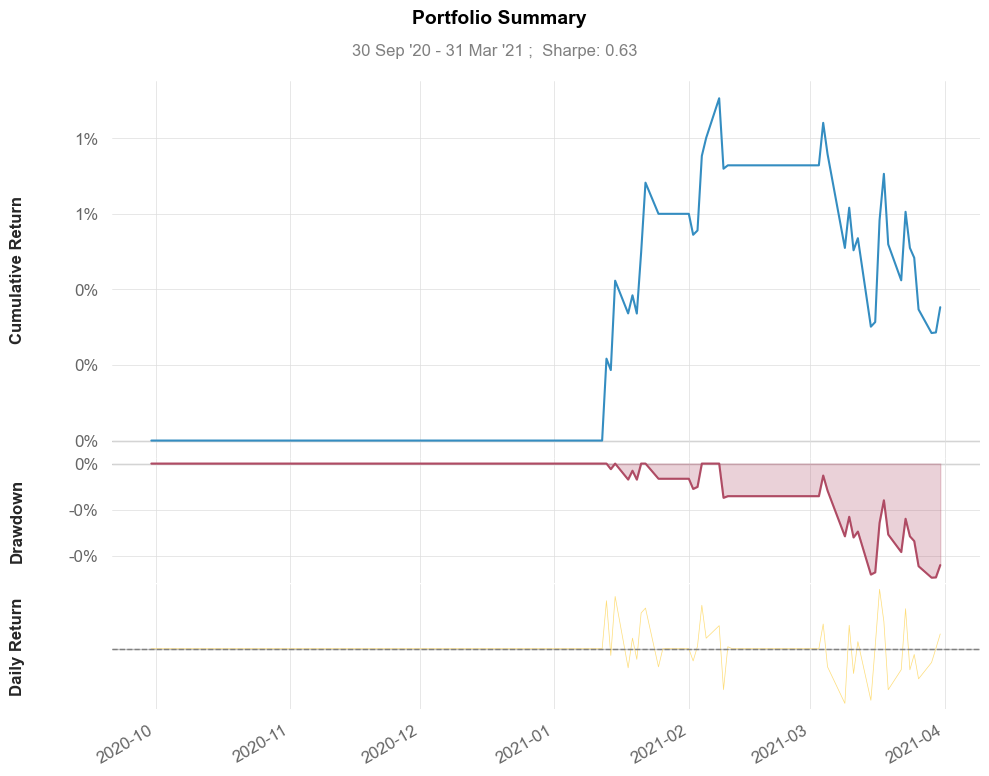

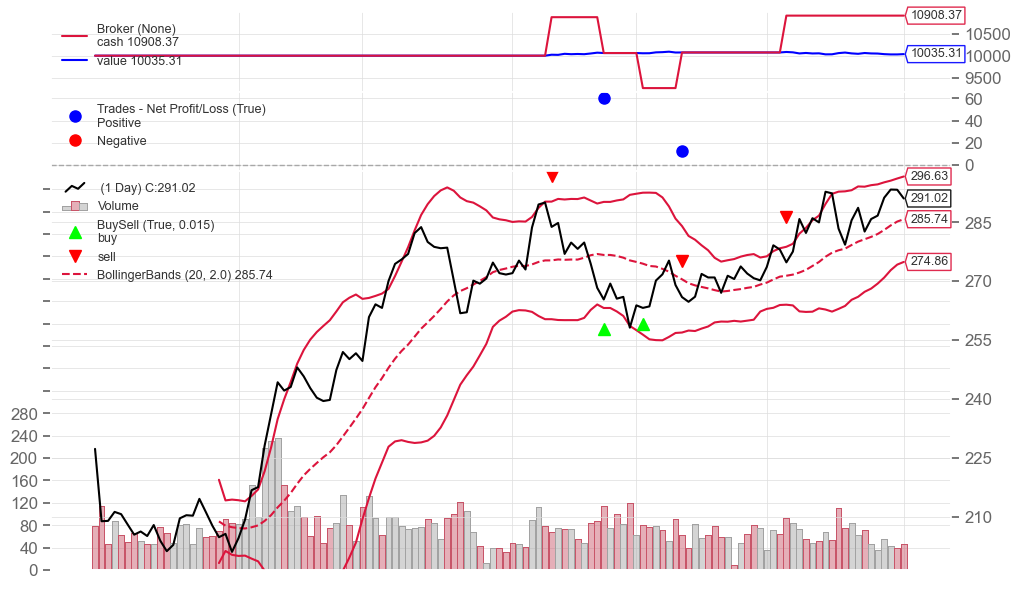

[[<Figure size 1000x600 with 4 Axes>]]

In [157]:
%matplotlib inline
print(get_strategy_stats(strategy))
plot_strategy_result(strategy)
cerebro.plot(iplot=False)

## Optimization

In [199]:
cerebro = bt.Cerebro(optreturn=False)
cerebro.adddata(data_feed)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
cerebro.optstrategy(BollingerBandStrategy, enable_log=False, use_predictor=True, change_sign_predictor=model, period=range(1, 20, 2), devfactor=[0.5, 1.125, 1.75, 2.375, 3.0])

cerebro.addsizer(bt.sizers.SizerFix, stake=3)
run = cerebro.run(maxcpus=1)

In [98]:
best_result["parameters"]

{'period': 3,
 'devfactor': 1.125,
 'predictor': LSTMModel(
   (lstm): LSTM(1, 50, batch_first=True)
   (linear): Linear(in_features=50, out_features=1, bias=True)
 ),
 'use_predictor': True,
 'enable_log': False,
 'min_hold_days': 1}

In [79]:
cerebro = bt.Cerebro()
cerebro.adddata(data_feed)

cerebro.addstrategy(BollingerBandStrategy, **best_result["parameters"])
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

cerebro.addsizer(bt.sizers.SizerFix, stake=3)
run = cerebro.run()

In [ ]:
# quantstats.reports.html(returns, output='stats.html', title='Bollinger bands')
# quantstats.reports.full(returns)

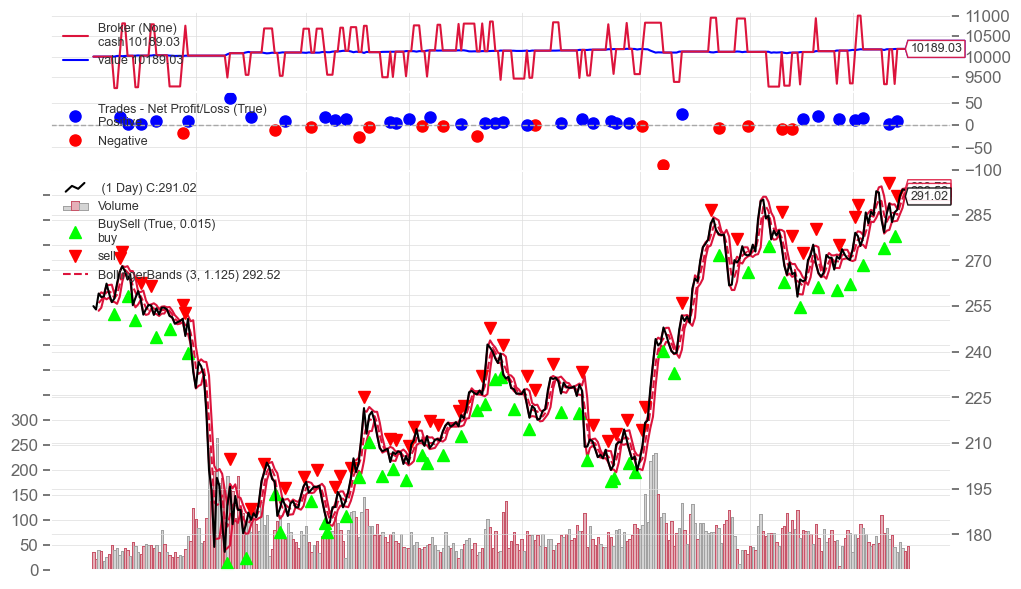

[[<Figure size 1000x600 with 4 Axes>]]

In [71]:
%matplotlib inline
cerebro.plot(iplot=False)

In [80]:
get_strategy_stats(run[0])

{'Sharpe Ratio': 1.3739689985231316, 'Profit': 0.018903000000001224}

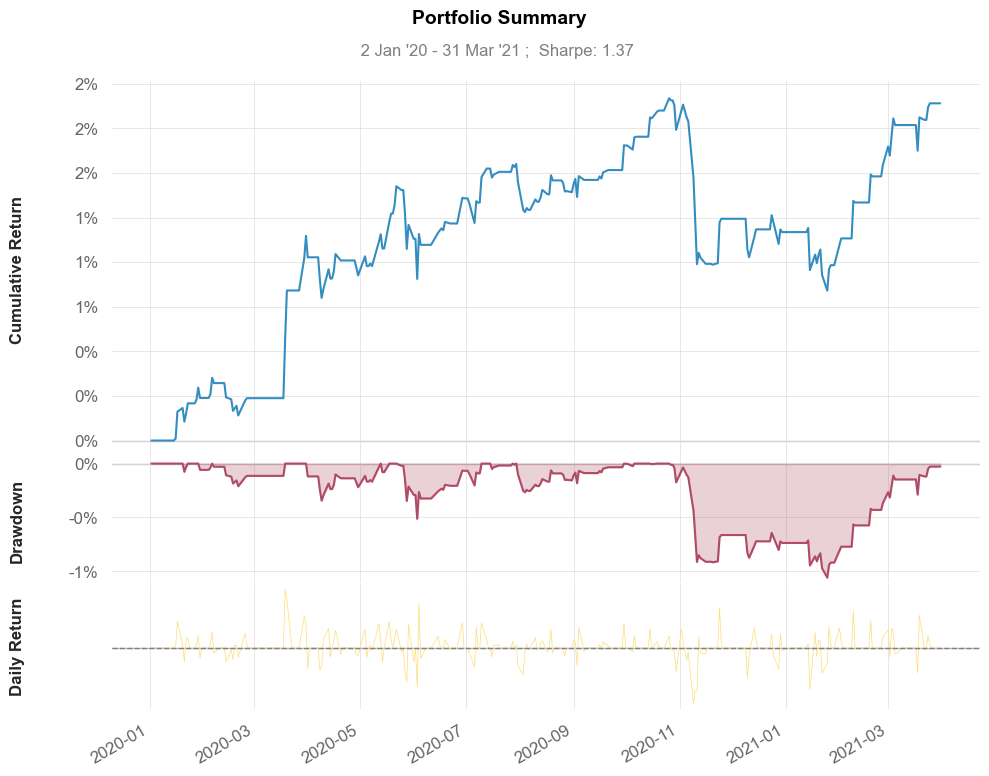

In [81]:
plot_strategy_result(run[0])

We can compare previous performance with the case where we do not use the forecasted predictions from the LSTM network.

In [83]:
dict(best_result["parameters"], use_predictor=False)

{'period': 3,
 'devfactor': 1.125,
 'predictor': LSTMModel(
   (lstm): LSTM(1, 50, batch_first=True)
   (linear): Linear(in_features=50, out_features=1, bias=True)
 ),
 'use_predictor': False,
 'enable_log': False}

In [84]:
cerebro = bt.Cerebro()
cerebro.adddata(data_feed)

cerebro.addstrategy(BollingerBandStrategy, **dict(best_result["parameters"], use_predictor=False))
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

cerebro.addsizer(bt.sizers.SizerFix, stake=3)
run = cerebro.run()

In [85]:
get_strategy_stats(run[0])

{'Sharpe Ratio': 0.12698069047646734, 'Profit': 0.0025260000000002503}

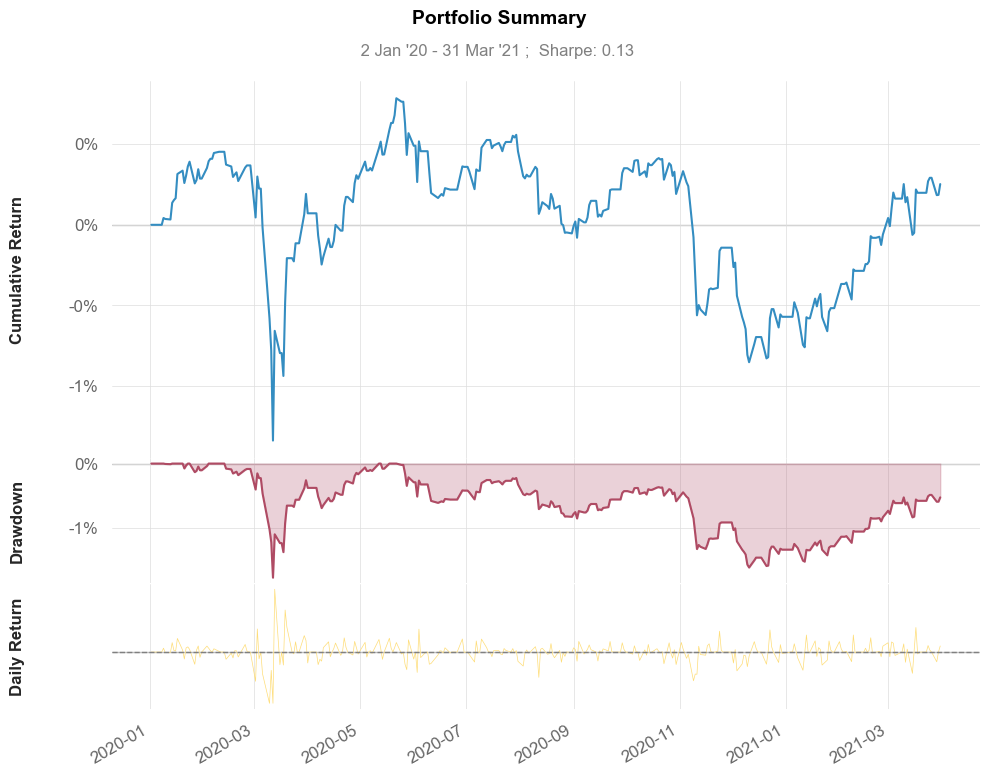

In [86]:
plot_strategy_result(run[0])

Now we compare with the best case when we don't use the predictor

In [87]:
cerebro = bt.Cerebro(optreturn=False)
cerebro.adddata(data_feed)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
cerebro.optstrategy(BollingerBandStrategy, enable_log=False, use_predictor=False, predictor=model, period=range(1, 20, 2), devfactor=[0.5, 1.125, 1.75, 2.375, 3.0])

cerebro.addsizer(bt.sizers.SizerFix, stake=3)
run = cerebro.run(maxcpus=1)

In [88]:
optimization_results = [
    dict(
        parameters=vars(strategy.params),
        stats=get_strategy_stats(strategy)
    )
    for iteration in run
    for strategy in iteration
]
    
best_result = max(optimization_results, key=lambda results: results["stats"]["Profit"])
best_index = optimization_results.index(best_result)

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

In [89]:
best_result["parameters"]

{'period': 3,
 'devfactor': 0.5,
 'predictor': LSTMModel(
   (lstm): LSTM(1, 50, batch_first=True)
   (linear): Linear(in_features=50, out_features=1, bias=True)
 ),
 'use_predictor': False,
 'enable_log': False}

In [90]:
cerebro = bt.Cerebro()
cerebro.adddata(data_feed)

cerebro.addstrategy(BollingerBandStrategy, **best_result["parameters"])
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

cerebro.addsizer(bt.sizers.SizerFix, stake=3)
run = cerebro.run()

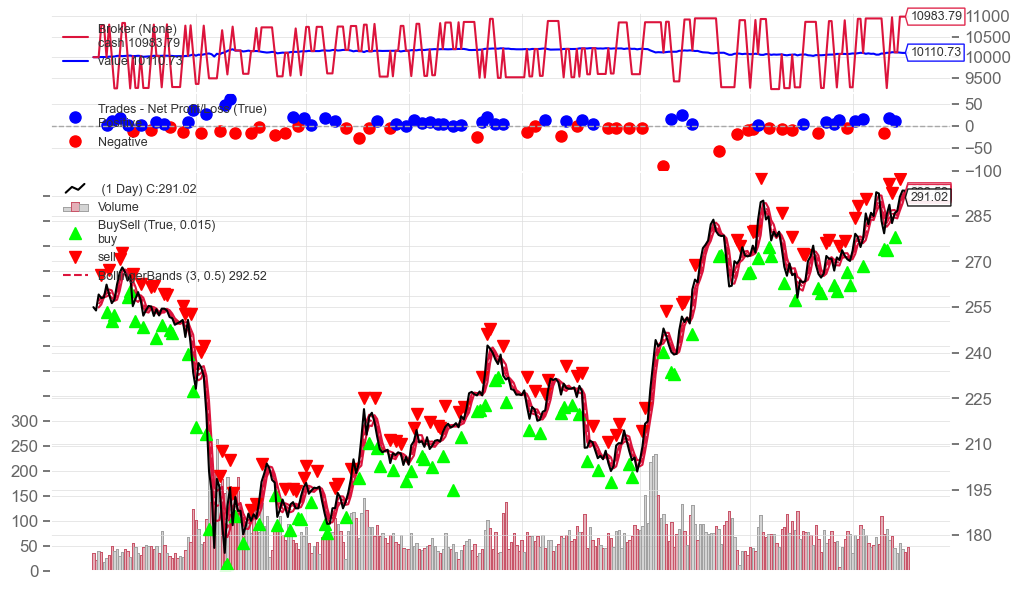

[[<Figure size 1000x600 with 4 Axes>]]

In [93]:
%matplotlib inline
cerebro.plot(iplot=False)

In [91]:
get_strategy_stats(run[0])

{'Sharpe Ratio': 0.5033974716785422, 'Profit': 0.011072999999999222}

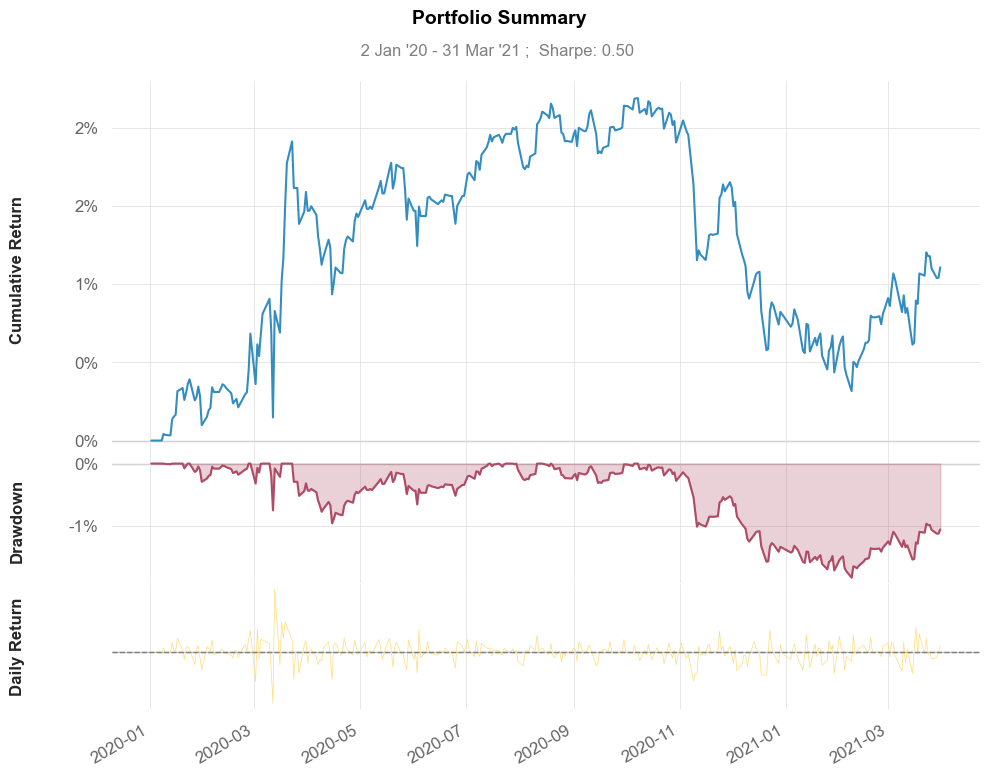

In [92]:
plot_strategy_result(run[0])

# Forcing to hold the position for at least 5 days

In [99]:
cerebro = bt.Cerebro(optreturn=False)
cerebro.adddata(data_feed)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
cerebro.optstrategy(BollingerBandStrategy, enable_log=False, min_hold_days=5, use_predictor=True, predictor=model, period=range(1, 20, 2), devfactor=[0.5, 1.125, 1.75, 2.375, 3.0])

cerebro.addsizer(bt.sizers.SizerFix, stake=3)
run = cerebro.run(maxcpus=1)

In [100]:
optimization_results = [
    dict(
        parameters=vars(strategy.params),
        stats=get_strategy_stats(strategy)
    )
    for iteration in run
    for strategy in iteration
]
    
best_result = max(optimization_results, key=lambda results: results["stats"]["Profit"])
best_index = optimization_results.index(best_result)

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

In [101]:
best_result["parameters"]

{'period': 3,
 'devfactor': 0.5,
 'predictor': LSTMModel(
   (lstm): LSTM(1, 50, batch_first=True)
   (linear): Linear(in_features=50, out_features=1, bias=True)
 ),
 'use_predictor': True,
 'enable_log': False,
 'min_hold_days': 5}

In [103]:
cerebro = bt.Cerebro()
cerebro.adddata(data_feed)

cerebro.addstrategy(BollingerBandStrategy, **best_result["parameters"])
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

cerebro.addsizer(bt.sizers.SizerFix, stake=3)
run = cerebro.run()

{'Sharpe Ratio': 1.0467484360733081, 'Profit': 0.025850999999997182}


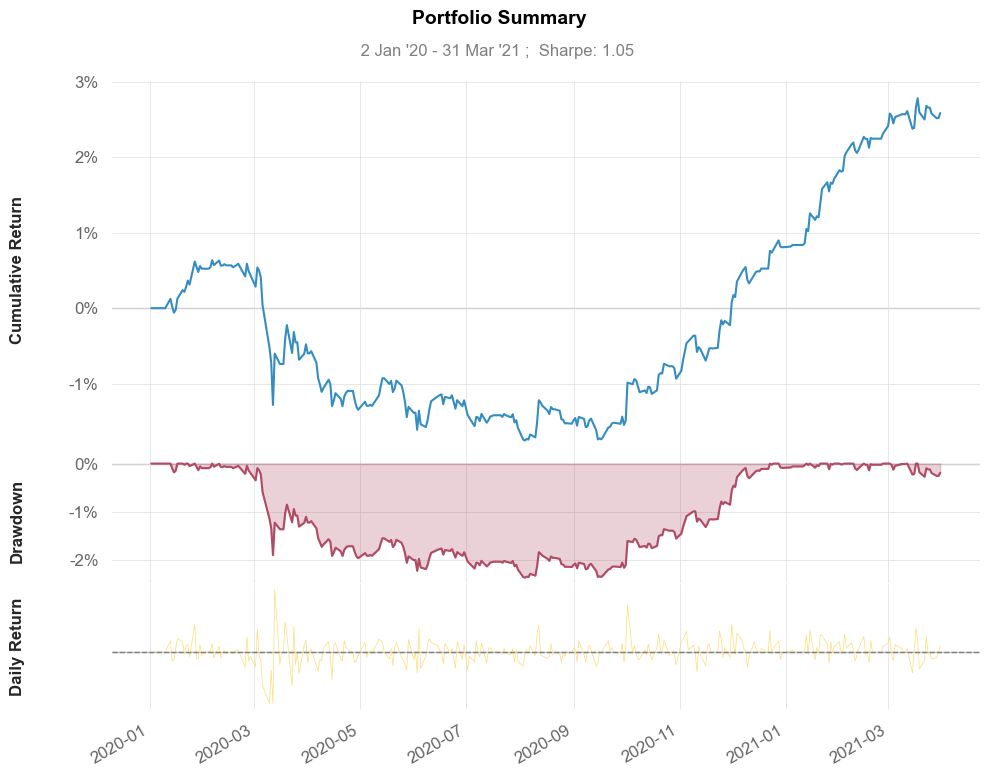

In [105]:
print(get_strategy_stats(run[0]))
plot_strategy_result(run[0])

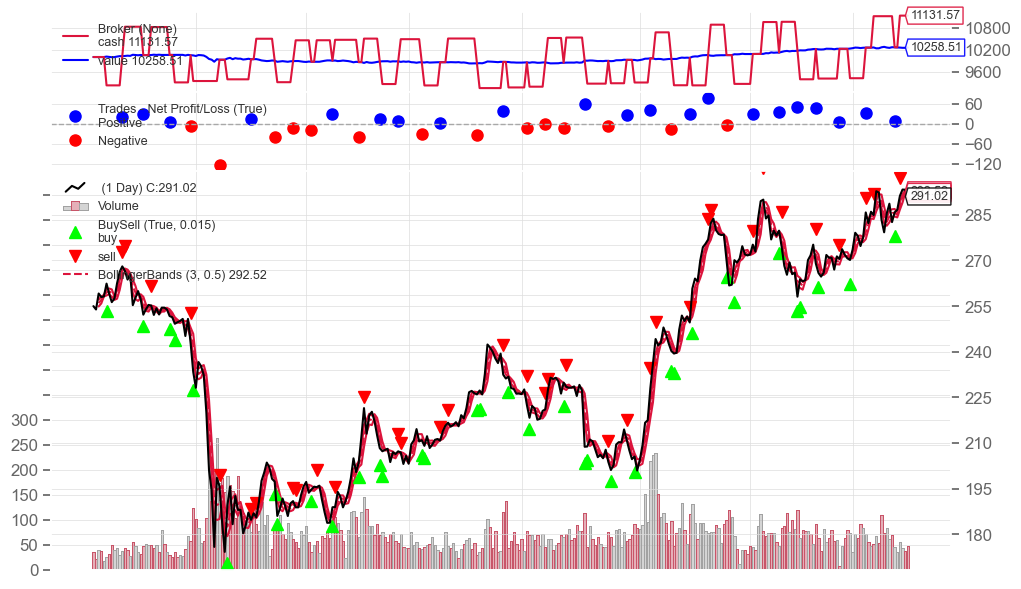

[[<Figure size 1000x600 with 4 Axes>]]

In [106]:
%matplotlib inline
cerebro.plot(iplot=False)

Try another stock

In [175]:
df = list(dfs.values())[1].copy()
df.index = df.index.to_timestamp()
data_feed = CSVData(dataname=df)

In [176]:
cerebro = bt.Cerebro(optreturn=False)
cerebro.adddata(data_feed)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
cerebro.optstrategy(BollingerBandStrategy, enable_log=False, min_hold_days=5, use_predictor=True, predictor=model, period=range(1, 20, 2), devfactor=[0.5, 1.125, 1.75, 2.375, 3.0])

cerebro.addsizer(bt.sizers.SizerFix, stake=3)
run = cerebro.run(maxcpus=1)

In [177]:
optimization_results = [
    dict(
        parameters=vars(strategy.params),
        stats=get_strategy_stats(strategy)
    )
    for iteration in run
    for strategy in iteration
]
    
best_result = max(optimization_results, key=lambda results: results["stats"]["Profit"])
best_index = optimization_results.index(best_result)

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\chana\PythonVirtualEnvironments\Project5ValueInvestor\Lib\site-packages\quantstats\stats.py:294: RuntimeWarning:

invalid value encountered in scalar divide

In [178]:
cerebro = bt.Cerebro()
cerebro.adddata(data_feed)

cerebro.addstrategy(BollingerBandStrategy, **best_result["parameters"])
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

cerebro.addsizer(bt.sizers.SizerFix, stake=3)
run = cerebro.run()

{'period': 3, 'devfactor': 1.125, 'predictor': LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
), 'use_predictor': True, 'enable_log': False, 'min_hold_days': 5}
{'Sharpe Ratio': 0.18176264258337846, 'Profit': 0.00036000000000102617}


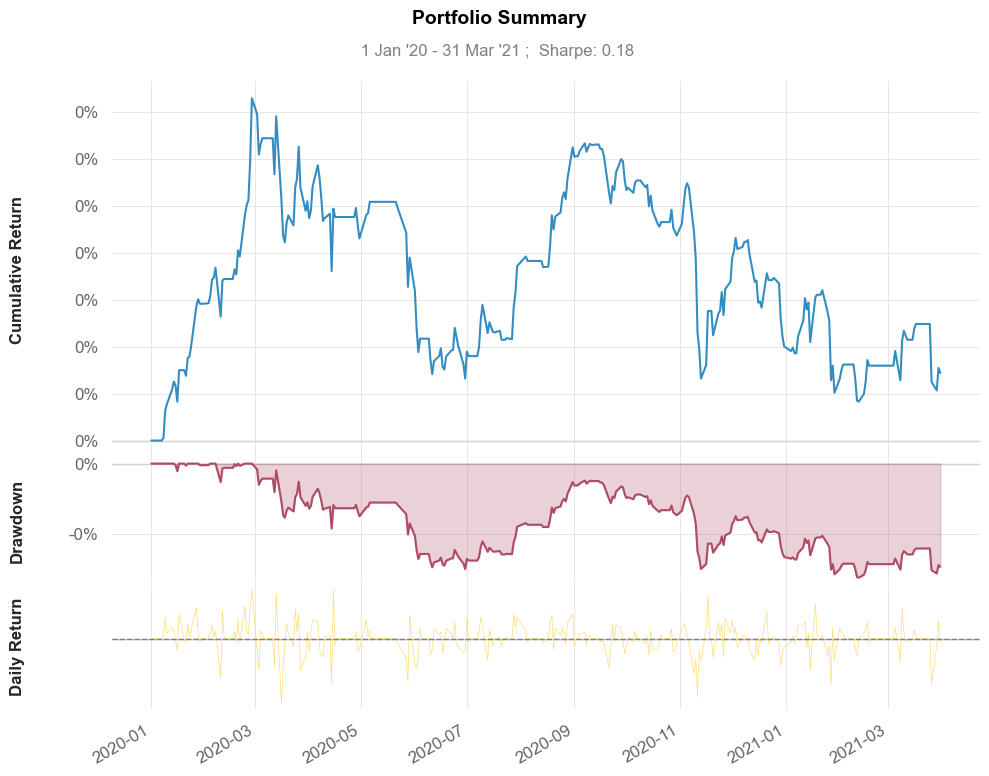

In [179]:
print(best_result["parameters"])
print(get_strategy_stats(run[0]))
plot_strategy_result(run[0])

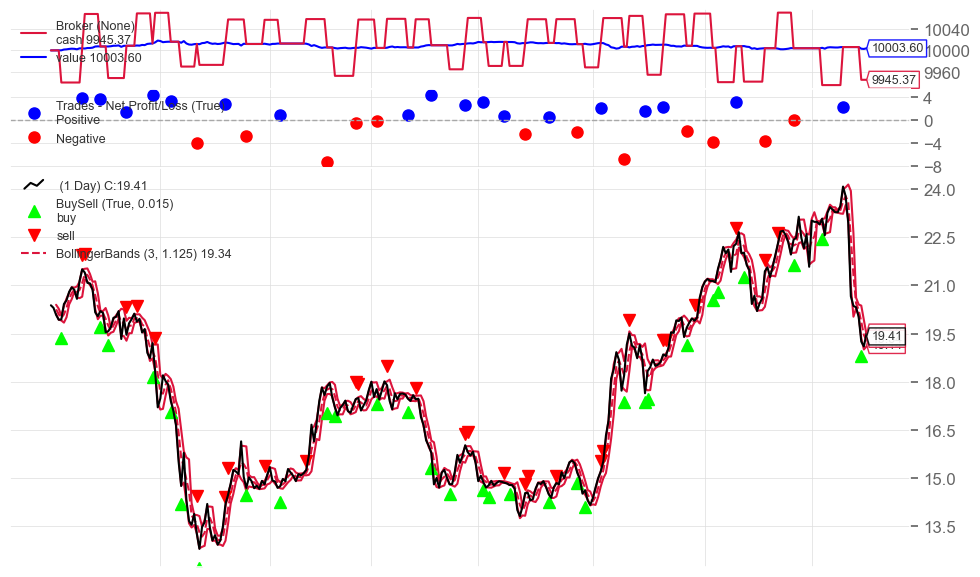

[[<Figure size 1000x600 with 3 Axes>]]

In [180]:
%matplotlib inline
cerebro.plot(iplot=False, volume=False)

In [181]:
quantstats.reports.metrics(get_strategy_returns(run[0]))

                    Strategy
------------------  ----------
Start Period        2020-01-02
End Period          2021-03-31
Risk-Free Rate      0.0%
Time in Market      75.0%

Cumulative Return   0.04%
CAGR﹪              0.02%

Sharpe              0.18
Prob. Sharpe Ratio  58.02%
Sortino             0.25
Sortino/√2          0.17
Omega               1.04

Max Drawdown        -0.16%
Longest DD Days     395

Gain/Pain Ratio     0.04
Gain/Pain (1M)      0.13

Payoff Ratio        0.82
Profit Factor       1.04
Common Sense Ratio  0.93
CPC Index           0.47
Tail Ratio          0.9
Outlier Win Ratio   5.82
Outlier Loss Ratio  3.21

MTD                 -0.0%
3M                  -0.02%
6M                  -0.11%
YTD                 -0.01%
1Y                  -0.09%
3Y (ann.)           0.02%
5Y (ann.)           0.02%
10Y (ann.)          0.02%
All-time (ann.)     0.02%

Avg. Drawdown       -0.03%
Avg. Drawdown Days  69
Recovery Factor     0.22
Ulcer Index         0.0
Serenity Index      0.02
